In [2]:
from astroquery.gaia import Gaia
from astroquery.esasky import ESASky
import numpy as np
from simbad_download import resolve_name
import pandas as pd
import pyvo as vo
import gaia_download as gd
from cross_match import add_panstarrs1, add_twomass
import matplotlib.pyplot as plt
from extinction import add_color, mag_abs, add_colors_and_abs_mag

Configuration file not found:

    /home/mjablons/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


1. arcesonds

GALEX cross-match: 3 arcseconds, even 5

In [3]:
sources = pd.read_csv('./found_cp_tails.csv')

In [4]:
gaia_data = gd.gaia_download_data(sources.source_id.values)

Executing Gaia query for 1050 sources...
Executing query...
INFO: Query finished. [astroquery.utils.tap.core]
Query finished!


In [5]:
sources_dr3 = pd.merge(left=gaia_data, right=sources[['source_id', 'TIC']], on='source_id', how='left')

In [6]:
sources_dr3.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,TIC
0,1636148068921376768,Gaia DR3 573545534662757504,573545534662757504,843580694,2016.0,10.732846,0.238209,84.682801,0.235746,0.523439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636148068921376768,Gaia DR3 573549009293487360,573549009293487360,117320301,2016.0,9.938466,0.017343,84.833263,0.015769,0.509673,...,0.3516,0.3785,0.3000,0.2862,0.3085,0.1604,0.1530,0.1649,PHOENIX,461598969.0
2,1636148068921376768,Gaia DR3 573549932709068416,573549932709068416,349334707,2016.0,12.411280,0.060851,84.778756,0.051277,0.479208,...,0.3281,0.4416,0.2968,0.2580,0.3485,0.1590,0.1382,0.1865,PHOENIX,NaN
3,1636148068921376768,Gaia DR3 573552475329793152,573552475329793152,1255013827,2016.0,12.264538,0.048599,84.907228,0.039843,0.532028,...,0.0679,0.1218,0.0764,0.0541,0.0973,0.0405,0.0287,0.0516,PHOENIX,461618421.0
4,1636148068921376768,Gaia DR3 573552651425754240,573552651425754240,1610097616,2016.0,11.786204,0.056529,84.867786,0.051901,0.572127,...,0.2256,0.2827,0.2018,0.1771,0.2226,0.1062,0.0932,0.1172,PHOENIX,NaN


In [7]:
sources_dr3 = add_colors_and_abs_mag(sources_dr3)

In [8]:
sources_all = sources_dr3

In [9]:
%matplotlib notebook  

In [10]:
from sklearn.ensemble import IsolationForest

In [11]:
sources_all = sources_all.dropna(subset=['BP-RP', 'G_abs'])

In [12]:
color_mag_abs = sources_all[['BP-RP', 'G_abs']]

In [13]:
clf = IsolationForest(contamination=0.25).fit_predict(color_mag_abs.values)

In [14]:
sources_all['outlier'] = clf

/tmp/ipykernel_66017/214367980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources_all['outlier'] = clf


<IPython.core.display.Javascript object>


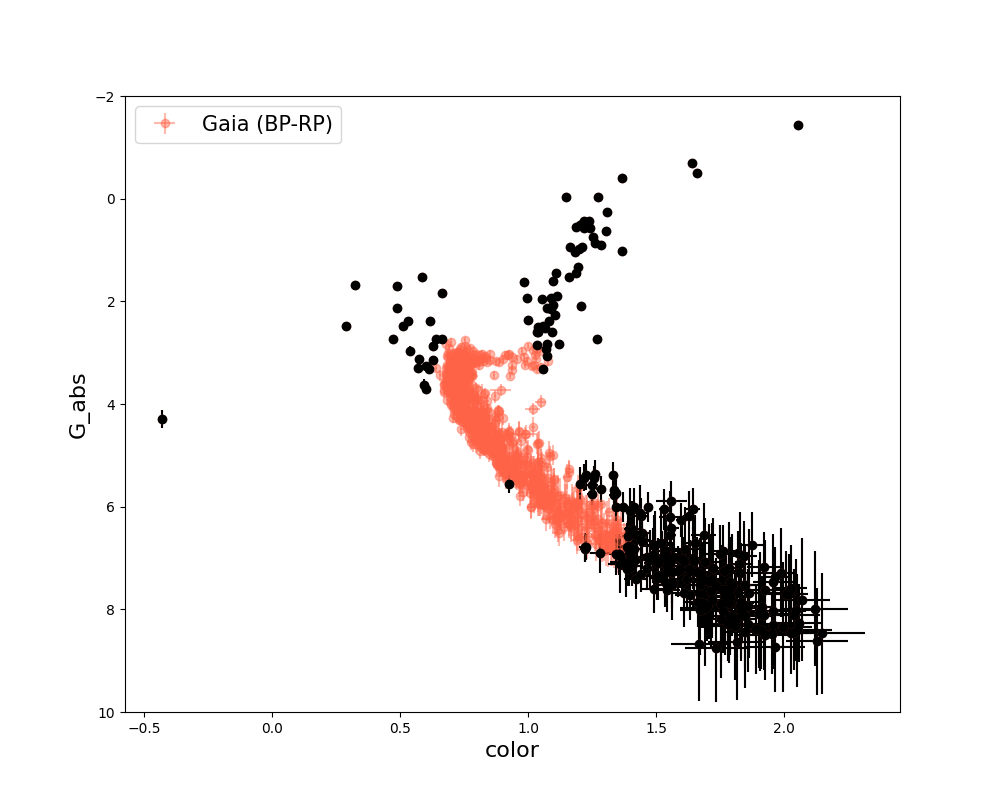

In [15]:
plt.figure(figsize=(10, 8))
plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='tomato', label='Gaia (BP-RP)', alpha=.45, fmt='o')
plt.errorbar(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
             xerr=sources_all[sources_all.outlier==-1]['BP-RP_error'],
             yerr=sources_all[sources_all.outlier==-1]['G_abs_error'],
            color='black', fmt='o', zorder=2);
plt.gca().invert_yaxis();
plt.legend(fontsize=15);
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.gca().set_ylim(10, -2);


In [16]:
isochrone = np.loadtxt('./cmd_test.dat', usecols=(28, 29, 30))

In [17]:
isochrone.shape

(297, 3)

In [18]:
isochrone = isochrone[isochrone[:, 1]<25]

<IPython.core.display.Javascript object>


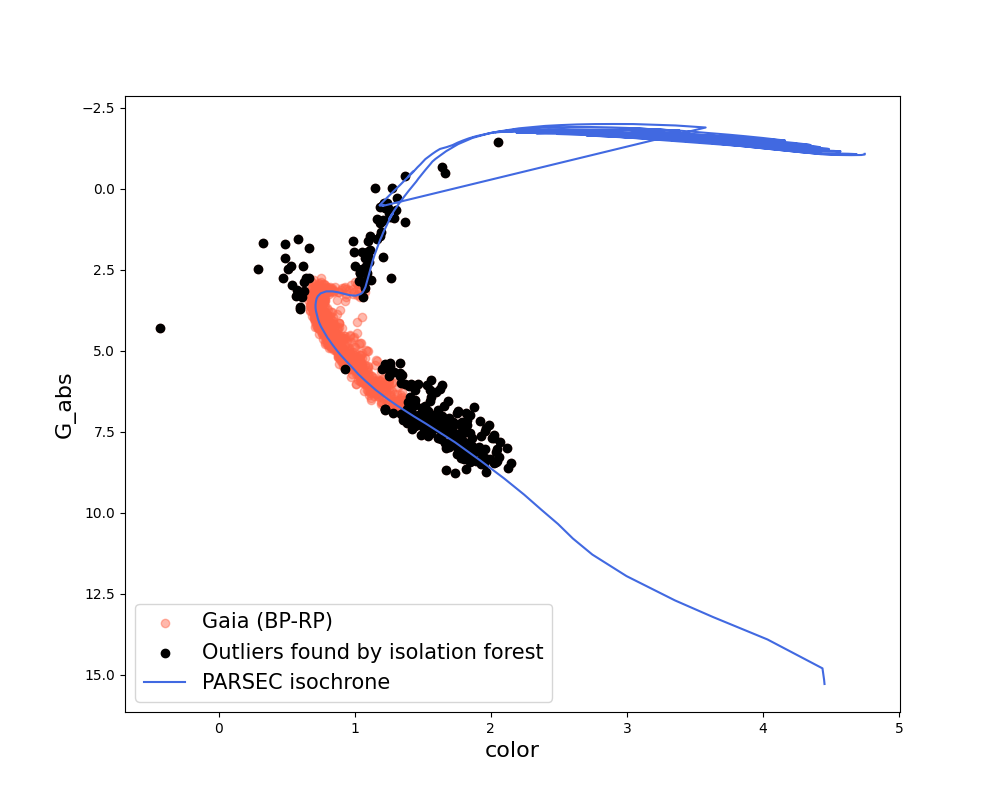

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[:, 1]-isochrone[:, 2], isochrone[:, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

Constrain the isochrone to the part that interests me

<IPython.core.display.Javascript object>


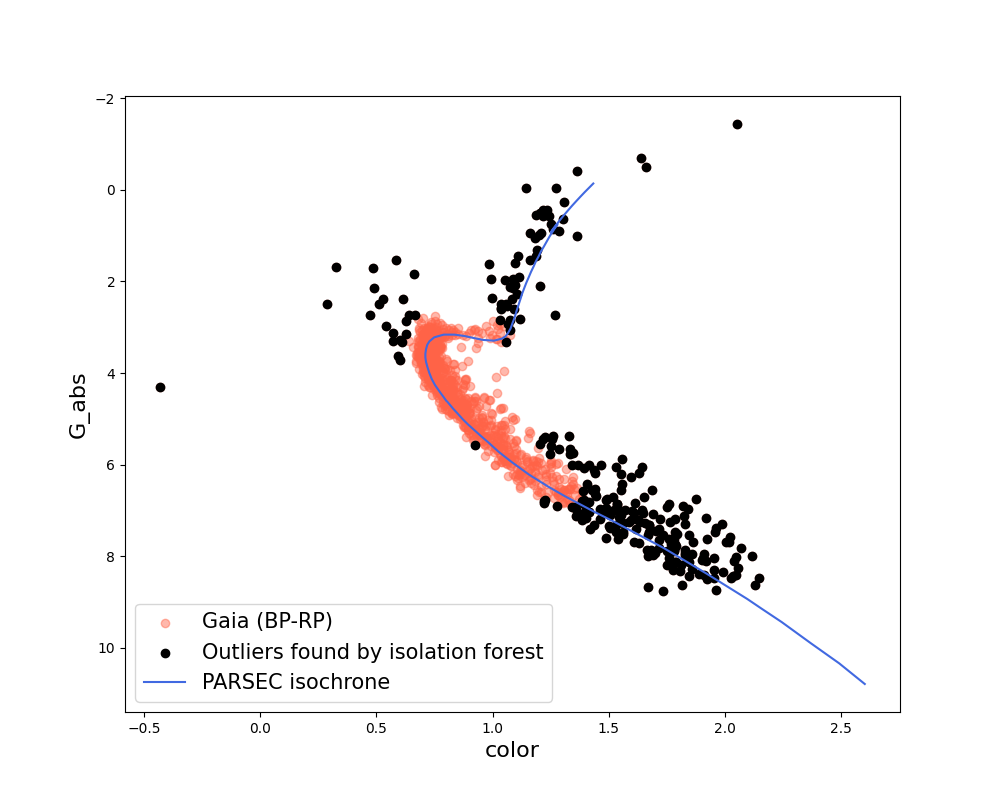

In [20]:
plt.figure(figsize=(10, 8))

isochrone_start_ind = 10
isochrone_end_ind = 100

plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[isochrone_start_ind:isochrone_end_ind, 1]-isochrone[isochrone_start_ind:isochrone_end_ind, 2],
         isochrone[isochrone_start_ind:isochrone_end_ind, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [21]:
isochrone_cut = isochrone[isochrone_start_ind:isochrone_end_ind]
isochrone_cut = np.concatenate([
    (isochrone_cut[:, 1]-isochrone_cut[:, 2]).reshape(-1, 1),
    isochrone_cut[:, 0].reshape(-1, 1)], axis=1)

In [87]:
eq_mass_isochrone = isochrone_cut+np.array([0., -0.75])

In [22]:
from scipy.interpolate import interp1d

In [91]:
BOUNDS = np.max(isochrone_cut, axis=0)-np.min(isochrone_cut, axis=0)

In [162]:
def closest(source, isochrone):
    two_closest = isochrone[
    np.argsort(
            np.linalg.norm((source-isochrone), axis=1).flatten()
        )
    ][:2]
    return two_closest[0], two_closest[1]

def distance_to_closest(source, isochrone):
    src_rescaled = source/BOUNDS
    isochrone_rescaled = isochrone/BOUNDS
    p1, p2 = closest(src_rescaled, isochrone_rescaled)
    return np.linalg.norm(np.cross((p2-p1), (p1-src_rescaled)))/np.linalg.norm((p2-p1))

def above_isochrone(source, isochrone):
    closest = isochrone[
        np.argsort(
                np.linalg.norm((source-isochrone), axis=1).flatten()
            )
    ][:3]
    p1 = closest[np.argmin(closest[:, 0])]
    p2 = closest[np.argmax(closest[:, 0])]
    v1 = (p2[0]-p1[0], p2[1]-p1[1])   # Vector 1
    v2 = (p2[0]-source[0], p2[1]-source[1])   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product

    #return source[1] <= point
    return xp>=0

In [163]:
dists = np.apply_along_axis(
    lambda x: distance_to_closest(x, isochrone_cut), 1,
    sources_all[['BP-RP', 'G_abs']].values)

In [164]:
above_equal_binary_limit = np.apply_along_axis(
    lambda x: above_isochrone(x, eq_mass_isochrone), 1,
    sources_all[['BP-RP', 'G_abs']].values)

<IPython.core.display.Javascript object>


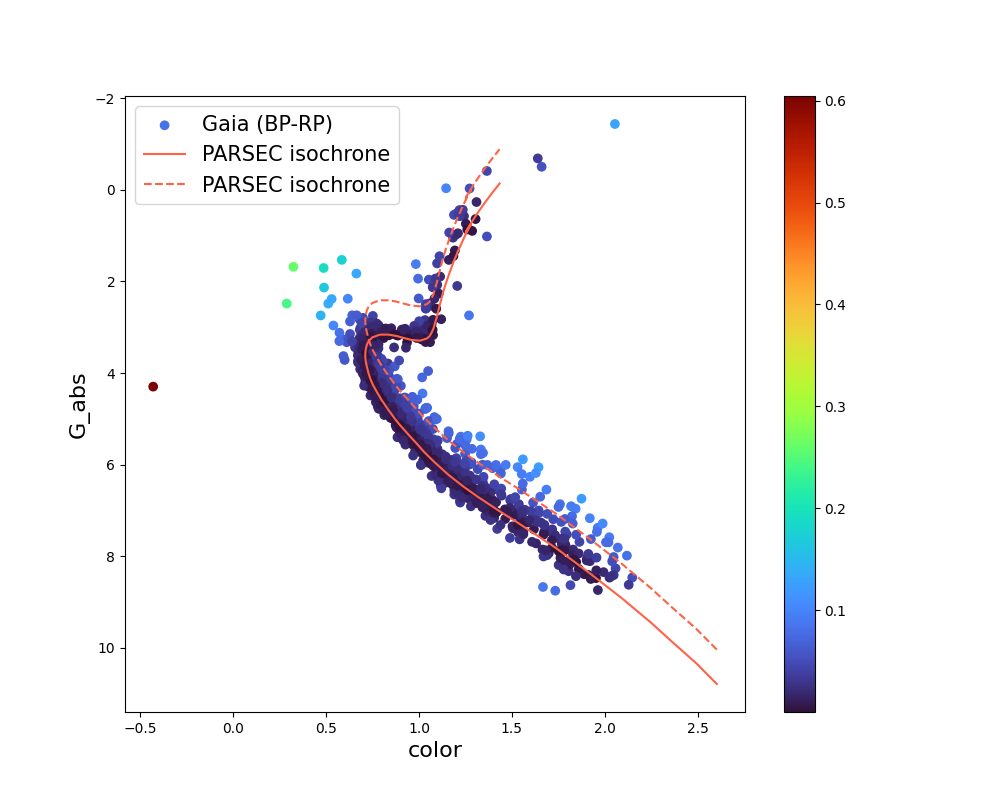

In [167]:
fig = plt.figure(figsize=(10, 8));
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            c=dists, cmap='turbo', label='Gaia (BP-RP)')
plt.colorbar()
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato')
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='PARSEC isochrone', color='tomato', linestyle='--')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [168]:
np.std(dists)

0.031913262522706605

<IPython.core.display.Javascript object>


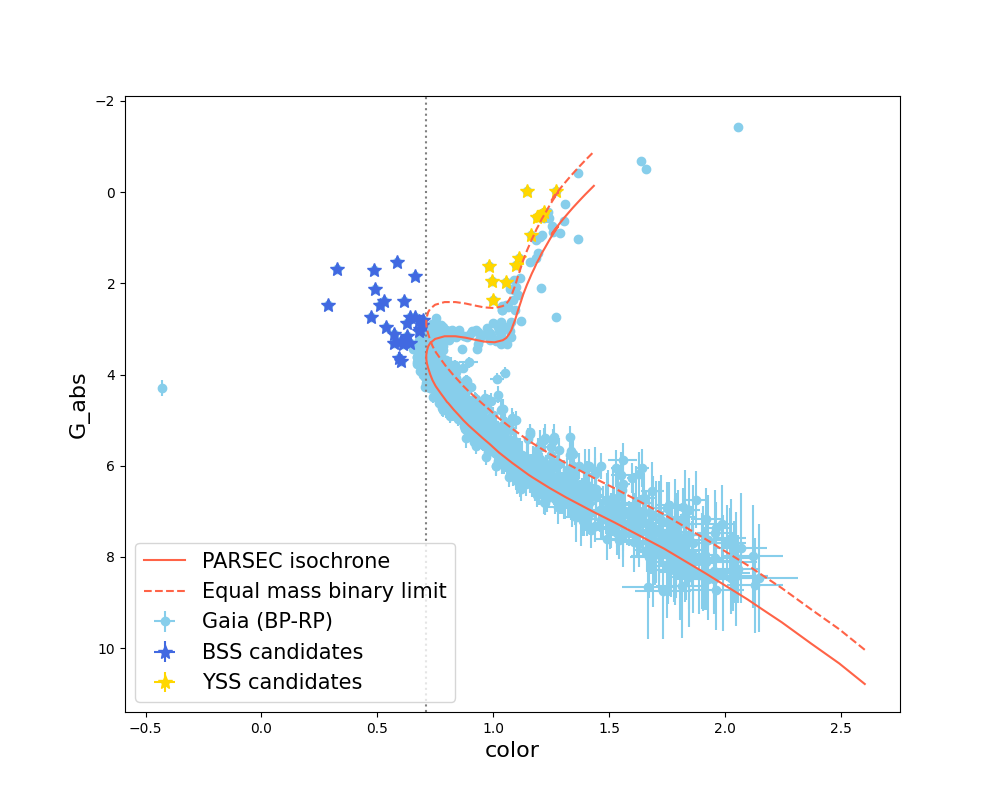

In [169]:
plt.figure(figsize=(10, 8));

TO_COLOR = np.min(isochrone_cut[:, 0])

plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='skyblue', label='Gaia (BP-RP)', fmt='o', zorder=1)
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato', zorder=3)
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='Equal mass binary limit', color='tomato', zorder=3, linestyle='--')
bss_candidates = sources_all[((dists>=np.std(dists)) & (sources_all['BP-RP']<TO_COLOR) & (sources_all['BP-RP']>0))]
yss_candidates = sources_all[(sources_all['BP-RP']>TO_COLOR) & (sources_all['G_abs']<2.5) & (sources_all['BP-RP']<2.) &
                             (((above_equal_binary_limit) & (dists>=np.std(dists))))]
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [170]:
len(bss_candidates)

27

In [171]:
len(yss_candidates)

13

In [172]:
bss_candidates.to_csv('./bss_candidates.csv', index=None)
yss_candidates.to_csv('./yss_candidates.csv', index=None)

# Download Gaia photometry if any

In [73]:
from astroquery.gaia import Gaia

In [74]:
len(yss_candidates[~np.isnan(yss_candidates.rv_amplitude_robust)])

7

In [75]:
def download_lightcurve(source_ids: np.ndarray) -> List[pd.DataFrame]:
    retrieval_type = 'ALL'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    
    lightcurves: List[pd.DataFrame] = []

    datalink = Gaia.load_data(ids=yss_candidates['source_id'],
                              data_release = data_release,
                              retrieval_type= 'EPOCH_PHOTOMETRY',
                              data_structure = data_structure,
                              verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()

    print(f'len{dl_keys} lightcurves found.')
    for dl_key in dl_keys:
        print(f'\tDownloading {dl_key}')
        lightcurves.append(datalink[dl_key][0].to_table().to_pandas())
        
    return lightcurves

NameError: name 'List' is not defined

In [ ]:
dl_out = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573941393208434688.xml'][0].to_table().to_pandas()

In [ ]:
dl_out

In [ ]:
plt.figure(figsize=(8, 5));

g_mag = dl_out[dl_out['band']=='G']
rp_mag = dl_out[dl_out['band']=='RP']
bp_mag = dl_out[dl_out['band']=='BP']

plt.errorbar(g_mag.time, g_mag.flux, yerr=g_mag.flux_error, c='black', fmt='o');
# plt.plot(rp_mag.time, rp_mag.mag, c='indianred');
# plt.plot(bp_mag.time, bp_mag.mag, c='royalblue');
# plt.gca().invert_yaxis();
plt.gca().set_xlabel('Time [d]', fontsize=16);
plt.gca().set_ylabel('Flux', fontsize=16);

In [ ]:
photo2 = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573941053907094144.xml'][0].to_table().to_pandas()

In [ ]:
photo2.head()

In [ ]:
from astropy.time import Time

In [ ]:
times = np.array([Time(t, format='mjd') for t in photo2.time.values])

In [ ]:
len(times)

In [ ]:
np.array(photo2.flux)

In [ ]:
t = TimeSeries(time=times)
t['flux'] = photo2.flux.values

In [ ]:
from astropy import units as u
from astropy.timeseries import BoxLeastSquares, TimeSeries
model = BoxLeastSquares(photo2.time.values*u.day, photo2.flux.values)  

In [ ]:
periodogram = model.autopower(0.01)

In [ ]:
plt.figure();
plt.plot(periodogram.period, periodogram.power)